In [1]:
import cv2
import base64
import requests
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
from io import BytesIO

In [2]:
class ModelServices():
    def __init__(self, iServers_config = None):
        self.servers_config = iServers_config if iServers_config else {}
    
    def set_detect_objects_server(self, iModel_url):
        self.servers_config["detect_objects"] = iModel_url

    def set_sam_server(self, iModel_url):
        self.servers_config["sam"] = iModel_url
    
    def set_clip_server(self, iModel_url):
        self.servers_config["clip"] = iModel_url

    def clip_image(self, iImage : Image, iTags):
        vBuffer = BytesIO()
        iImage.save(vBuffer, format="JPEG")
        vImageBase64 = base64.b64encode(vBuffer.getvalue()).decode('utf-8')
        
        vJsonRequest = {
            "image": vImageBase64,
            "tags": iTags
        }
        vResponse = requests.post(
            self.servers_config["clip"] + "/genera/clip",
            json = vJsonRequest
        )

        return vResponse.json()["data"]

    def detect_objects(self, iImage : Image, iSearched_label = list(), iRoundBoxes = True):
        vBuffer = BytesIO()
        iImage.save(vBuffer, format="JPEG")
        vImageBase64 = base64.b64encode(vBuffer.getvalue()).decode('utf-8')
        
        vJsonRequest = {
            "image": vImageBase64
        }
        vResponse = requests.post(
            self.servers_config["detect_objects"] + "/genera/object_detection",
            json = vJsonRequest
        )

        vResponse = vResponse.json()["data"]
        vFilteredResult = [x for x in vResponse if x["label_name"] in iSearched_label or iSearched_label is None or len(iSearched_label) == 0]
        for tResult in vFilteredResult:
            tResult["box"] = [(round(x) if iRoundBoxes else x) for x in tResult["box"]]
            
            vWidth = tResult["box"][2] - tResult["box"][0]
            vHeigth = tResult["box"][3] - tResult["box"][1]
            tResult["width"] = vWidth
            tResult["heith"] = vHeigth
            tResult["area"] = vWidth * vHeigth
            tResult["relative_area"] = (vWidth * vHeigth) / (iImage.size[0] * iImage.size[1])
        return vFilteredResult

    def generate_masks(self, iImage, iBoxes):
        vBuffer = BytesIO()
        iImage.save(vBuffer, format="JPEG")
        vImageBase64 = base64.b64encode(vBuffer.getvalue())
        vImageBase64 = vImageBase64.decode('utf-8')
        vJsonRequest = {
            "image": vImageBase64,
            "boxes": iBoxes,
            "shape": iImage.size
        }

        vResponse = requests.post(
            self.servers_config["sam"] + "/genera/segments/box",
            json = vJsonRequest
        )
        vMasks = list()
        for tMask in vResponse.json()["masks"]:
            tMask = base64.b64decode(tMask)
            tMask = Image.open(BytesIO(tMask))
            vMasks.append(tMask)
        return vMasks

gAIServer = ModelServices()
gAIServer.set_clip_server("http://localhost:82")
gAIServer.set_detect_objects_server("http://localhost:88")
gAIServer.set_sam_server("http://localhost:80")

In [3]:
def plot_images(iImages, iFigSize = (5, 5)):
    if isinstance(iFigSize, int):
        iFigSize = (iFigSize, iFigSize)
    if isinstance(iImages, list) and len(iImages) > 1:
        plt.figure(figsize = iFigSize)
        _, vAxisArray = plt.subplots(1, len(iImages), figsize = iFigSize)
        for i, tImage in enumerate(iImages):
            vAxisArray[i].imshow(tImage)
            vAxisArray[i].axis('off')
        plt.show()
    else:
        vImage = iImages[0] if isinstance(iImages, list) and len(iImages) == 1 else iImages
        plt.figure(figsize = iFigSize)
        plt.imshow(vImage)
        plt.axis('off')
        plt.show()

# This is only for remenber as to use it.
def numpy2pillow(iNumpyArray : np.ndarray) -> Image:
    return Image.fromarray(iNumpyArray)

# This is only for remenber as to use it.
def pillow2numpy(iImage : Image) -> np.ndarray:
    return np.array(iImage)

def draw_boxes(iImage, iBoxes, iColor, iWidth):
    vImage = iImage.copy()
    vDraw = ImageDraw.Draw(vImage)
    for tBox in [x for x in iBoxes]:
        vDraw.rectangle(tBox["box"], outline = iColor, width = iWidth)
    return vImage

def crop_image(iImage, iBox):
    vImgArray = np.array(iImage)
    vImage = vImgArray[ iBox[1] : iBox[3] , iBox[0] : iBox[2]]
    vImage = Image.fromarray(vImage)
    return vImage

def remove_mask(iImage, iMask, iInverseRemove : bool = False):
    vImage = np.array(iImage)
    vMask  = np.array(iMask)
    
    vAlphaChannel = vMask * np.ones(vImage.shape[:2], dtype = np.uint8)
    if iInverseRemove:
        vAlphaChannel = 255 - vAlphaChannel

    return Image.fromarray(np.dstack((vImage, vAlphaChannel)))

def combine_masks(iMaskList):
    vMaskResult = iMaskList[0]
    for iMask in iMaskList:
        vMaskResult = np.maximum(vMaskResult, iMask)
    return vMaskResult

In [4]:
def get_general_memory(iFilePath):
    vVideoCapture = cv2.VideoCapture(iFilePath)
    vSucces, vFrame = vVideoCapture.read()
    vIndex = 0
    vFrames = list()
    while vSucces:
        vFrame = cv2.cvtColor(vFrame, cv2.COLOR_BGR2RGB)
        vFrames.append({
            "image": Image.fromarray(vFrame),
            "detected_objects": None,
            "frame_index": vIndex,
            "masked_objects": None
        })

        vSucces, vFrame = vVideoCapture.read()
        vIndex = vIndex + 1
    return vFrames

def get_framerate_and_fourcc(iFilePath):
    vVideoCapture = cv2.VideoCapture(iFilePath)
    vFrameRate = vVideoCapture.get(cv2.CAP_PROP_FPS)
    vFourcc = int(vVideoCapture.get(cv2.CAP_PROP_FOURCC))
    vVideoCapture.release()

    return vFrameRate, vFourcc

def detect_objects_of_the_video(iGeneral_memory, iLabel = None, iMinRelation = 0):
    for tFrame in iGeneral_memory:
        print(f"\rProcesing frame", tFrame["frame_index"], end = "")
        vFrame = tFrame["image"]
        tFrame["detected_objects"] = gAIServer.detect_objects(vFrame, iLabel)
        tFrame["detected_objects_filtered"] = [x for x in tFrame["detected_objects"] if x["relative_area"] >= iMinRelation]

def save_frames2video(iFilePath, iListImages, iFrameRate):
    vVideoWriter = cv2.VideoWriter(
        iFilePath,
        cv2.VideoWriter_fourcc(*'MP4V'),
        iFrameRate,
        (iListImages[0].size[0], iListImages[0].size[1])
    )

    try:
        for tFrame in iListImages:
            tFrame = np.array(tFrame)
            tFrame = cv2.cvtColor(tFrame, cv2.COLOR_RGB2BGR)
            vVideoWriter.write(tFrame)
    finally:
        vVideoWriter.release()

def mask_objects_f_of_the_video(iGeneral_memory, iLabel = None, iMinRelation = 0):
    for tFrame in iGeneral_memory:
        print(f"\rProcesing frame", tFrame["frame_index"], end = "")
        vFrame = tFrame["image"]
        vBoxesF = [x["box"] for x in tFrame["detected_objects"] if x["relative_area"] >= iMinRelation]
        tFrame["masked_objects"] = gAIServer.generate_masks(vFrame, vBoxesF)


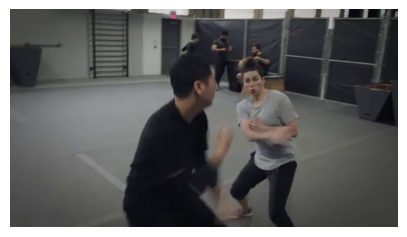

In [5]:
cVIDEO_FILE = "../resources/video/videoplayback.mp4"
cVIDEO_FILE_BOXES = "../resources/video/video_boxes.mp4"

gFrameRate, gFourcc = get_framerate_and_fourcc(cVIDEO_FILE)
gGeneralMemory = {
    "frames": get_general_memory(cVIDEO_FILE)[0:500],
    "characters": [
        {"character_id": 1, "description": "Person with gray t-shirt"},
        {"character_id": 2, "description": "Person with black t-shirt"},
        {"character_id": 3, "description": "Man with beard and gray t-shirt"}
    ]
}
plot_images(gGeneralMemory["frames"][70]["image"], 5)

<Figure size 800x800 with 0 Axes>

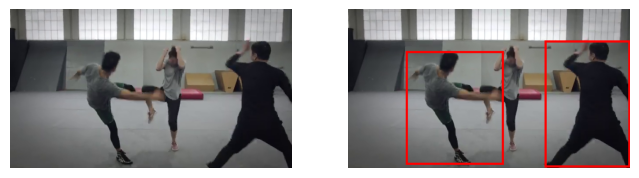

<Figure size 800x800 with 0 Axes>

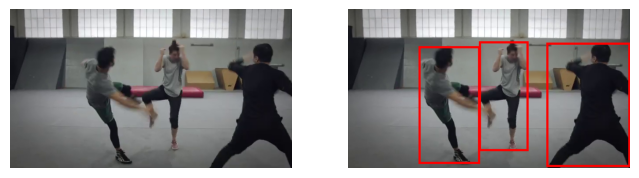

In [40]:
detect_objects_of_the_video(gGeneralMemory["frames"], "person", 0.1)

for tData in gGeneralMemory["frames"][480:482]:
    tImage = tData["image"]
    tImgWithBoxes = draw_boxes(tImage, tData["detected_objects_filtered"], "red", 5)
    plot_images([tImage, tImgWithBoxes], 8)

<Figure size 1500x1500 with 0 Axes>

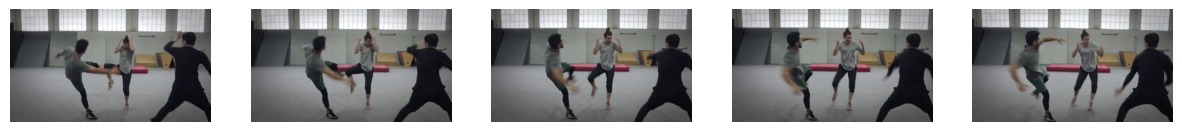

<Figure size 1500x1500 with 0 Axes>

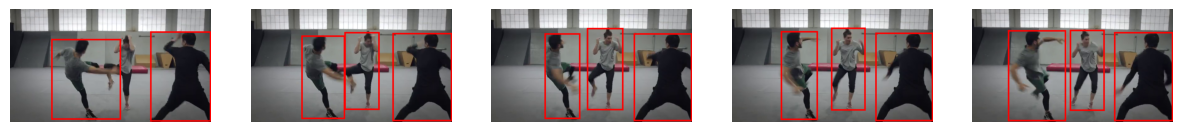

In [41]:
gFrames = [x["image"] for x in gGeneralMemory["frames"]]
gFrameBoxes = [draw_boxes(x["image"], x["detected_objects_filtered"], "red", 5) for x in gGeneralMemory["frames"]]

plot_images(gFrames[480:485], 15)
plot_images(gFrameBoxes[480:485], 15)

In [32]:
save_frames2video(cVIDEO_FILE_BOXES, gFrameBoxes, gFrameRate)
print("Video saved.")

Video saved.


Procesing frame 484

<Figure size 500x500 with 0 Axes>

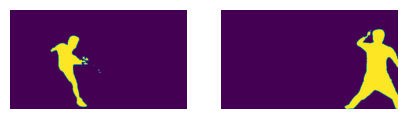

<Figure size 500x500 with 0 Axes>

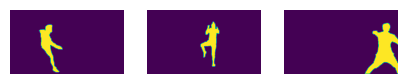

<Figure size 500x500 with 0 Axes>

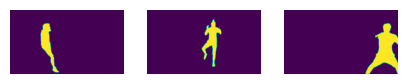

<Figure size 500x500 with 0 Axes>

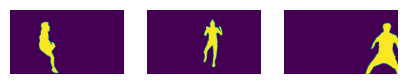

<Figure size 500x500 with 0 Axes>

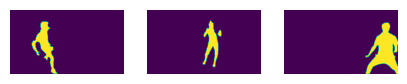

In [43]:
mask_objects_f_of_the_video(gGeneralMemory["frames"][480:485], "person", 0.1)

for tData in gGeneralMemory["frames"][480:485]:
    tImage = tData["image"]
    tImgWithBoxes = draw_boxes(tImage, tData["detected_objects_filtered"], "red", 5)
    plot_images(tData["masked_objects"], 5)

In [47]:
def load_crop_images(iImage, iBoxes, iMasks):
    vImagesCropped = list()
    for tBox, tMask in zip(iBoxes, iMasks):
        tImage = crop_image(iImage, tBox)
        tMask = crop_image(tMask, tBox)
        tImage = remove_mask(tImage, tMask)
        vImagesCropped.append(tImage)
    return vImagesCropped

for tFrame in gGeneralMemory["frames"]:
    tObjects = tFrame["detected_objects_filtered"]
    tBoxes = [x["box"] for x in tObjects]
    if tFrame["masked_objects"] is not None:
        tImageCropped = load_crop_images(
            tFrame["image"],
            tBoxes,
            tFrame["masked_objects"]
        )
        for tObject, tImage in zip(tObjects, tImageCropped):
            tObject["image_cropped"] = tImage

<Figure size 500x500 with 0 Axes>

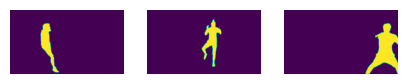

<Figure size 500x500 with 0 Axes>

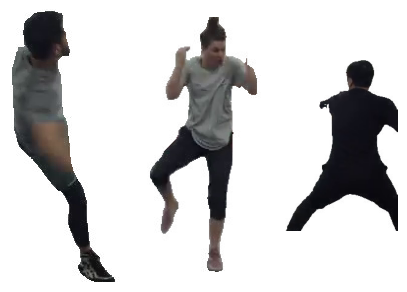

In [50]:
gImageCropped = [x["image_cropped"] for x in gGeneralMemory["frames"][482]["detected_objects_filtered"]]

plot_images(gGeneralMemory["frames"][482]["masked_objects"])
plot_images(gImageCropped)

<Figure size 1000x1000 with 0 Axes>

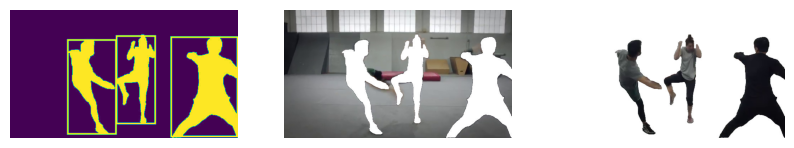

In [52]:
gImageWithoutPersons = None
gImageOnlyPersons = None
gMaskWithBox = None
for tData in gGeneralMemory["frames"][481:482]:
    tImage = tData["image"]
    #tImgWithBoxes = draw_boxes(tImage, tData["detected_objects_filtered"], "red", 5)
    gMaskCombined = Image.fromarray(combine_masks(tData["masked_objects"]))
    gMaskWithBox = draw_boxes(gMaskCombined, tData["detected_objects_filtered"], "white", 5)
    gImageWithoutPersons = remove_mask(tImage, gMaskCombined, True)
    gImageOnlyPersons = remove_mask(tImage, gMaskCombined, False)
    break

plot_images([gMaskWithBox, gImageWithoutPersons, gImageOnlyPersons], 10)

Person with black t-shirt


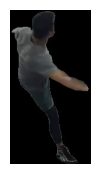

Woman with gray t-shirt


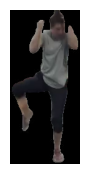

Person with black t-shirt


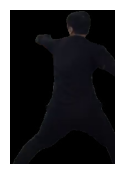

In [67]:
def rgba2rgb(iImage):
    vRGB = iImage.copy()
    vRGB = iImage[:, :, :3]
    vAlpha = iImage[:, :, 3]
    vAlpha = vAlpha / 255
    vRGB = vRGB * vAlpha[:, :, None]
    vRGB = vRGB.astype(np.uint8)
    return vRGB

gGeneralMemory["characters"] = [
    {"character_id": 1, "description": "Woman with gray t-shirt", "prompt": ""},
    {"character_id": 2, "description": "Person with black t-shirt", "prompt": ""},
    {"character_id": 3, "description": "Man with beard and gray t-shirt", "prompt": ""}
]

gTags = [x["description"] for x in gGeneralMemory["characters"]]
for tFrame in gGeneralMemory["frames"][481:482]:
    tObjects = tFrame["detected_objects_filtered"]
    for tObj in tObjects:
        if "masked_objects" in tFrame:
            tImage = np.array(tObj["image_cropped"])
            tImage = rgba2rgb(tImage)
            tImage = Image.fromarray(tImage)
            vResult = gAIServer.clip_image(tImage, gTags)
            vMaxResult = round(max(vResult), 2)
            vResult = [t for p, t in zip(vResult, gTags) if round(p, 2) == vMaxResult][0]
            print(vResult)
            plot_images(tImage, 2)